# Loading data and model

In [1]:
import torch 
from XTSCBench.ClassificationModels.CNN_T import ResNetBaseline, UCRDataset,fit, get_all_preds

from XTSCBench.ClassificationModels.LSTM import LSTM
from XTSCBench.CounterfactualEvaluation import CounterfactualEvaluation
from tslearn.datasets import UCR_UEA_datasets
import sklearn
import numpy as np 
import os


2024-12-02 02:05:04.477180: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-02 02:05:04.609309: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-02 02:05:04.634848: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-02 02:05:04.634867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-02 02:05:04.634881: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

In [51]:
dataset='Epilepsy' # ECG200, ECG5000, Epilepsy
# dataset = 'ptbxl'

In [52]:



if dataset in ['ECG200','ECG5000','Epilepsy']:
    train_x, train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
elif dataset == 'ptbxl':
    train_x = np.load(f'./datasets/ptbxl/x_train.npy')
    train_y = np.load(f'./datasets/ptbxl/y_train.npy')
    test_x = np.load(f'./datasets/ptbxl/x_test.npy')
    test_y = np.load(f'./datasets/ptbxl/y_test.npy')

# 1 hot encoding outcomes
enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))    

n_pred_classes =train_y.shape[1]
NumTimesteps = train_x.shape[-2]
NumFeatures = train_x.shape[-1]

train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)


In [53]:
# Loading model
model_path = './trained_models'

device='cpu'
hidden_size=10
rnn=0.1
input_size = train_x.shape[-1] # univariate or multi?

NumTimesteps = train_x.shape[-2]
NumFeatures = train_x.shape[-1]
# Model saved by this name
model_name = f'lstm_{dataset}_h{hidden_size}_drop{rnn}'

if dataset=='Epilepsy':
    model_name = 'lstm_Epilepsy_h200_drop0.3_acc58'



if os.path.isfile(f'./{model_path}/{model_name}'):
    model = torch.load(f'./{model_path}/{model_name}')
    print(f"Model {model_name} successfully loaded")
else:
    print("Model not found. Please train model using training_models.ipynb and provide in this notebook")

model.eval()


Model lstm_Epilepsy_h200_drop0.3_acc58 successfully loaded


LSTM(
  (drop): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=200, out_features=4, bias=True)
  (rnn): LSTM(3, 200, batch_first=True)
)

In [54]:
model.eval()
y_pred,labels= get_all_preds(model,test_loader)

In [55]:
# Selecting a sample to explain

observation_01, label_01 = test_dataset[0]
label_01=np.array([y_pred[0]])
print(observation_01.shape)
print(label_01.shape)

(206, 3)
(1,)


In [56]:
observation_01.reshape(1,3,-1).shape

(1, 3, 206)

In [57]:
observation_01[np.newaxis].shape

(1, 206, 3)

# Explaining Outcomes

## 1. TSevo

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt


In [59]:
from TSInterpret.InterpretabilityModels.counterfactual.TSEvoCF import TSEvo

tsevo_exp = TSEvo(model= model,data=(train_x,train_y), mode = 'time',backend='PYT',epochs=500)

y was one Hot Encoded


In [60]:
# explaining the outcome of a sample
pop,label_cf=tsevo_exp.explain(observation_01[np.newaxis],np.array(label_01))

No Target


In [61]:
label_cf.shape, pop.shape

((4,), (3, 206))

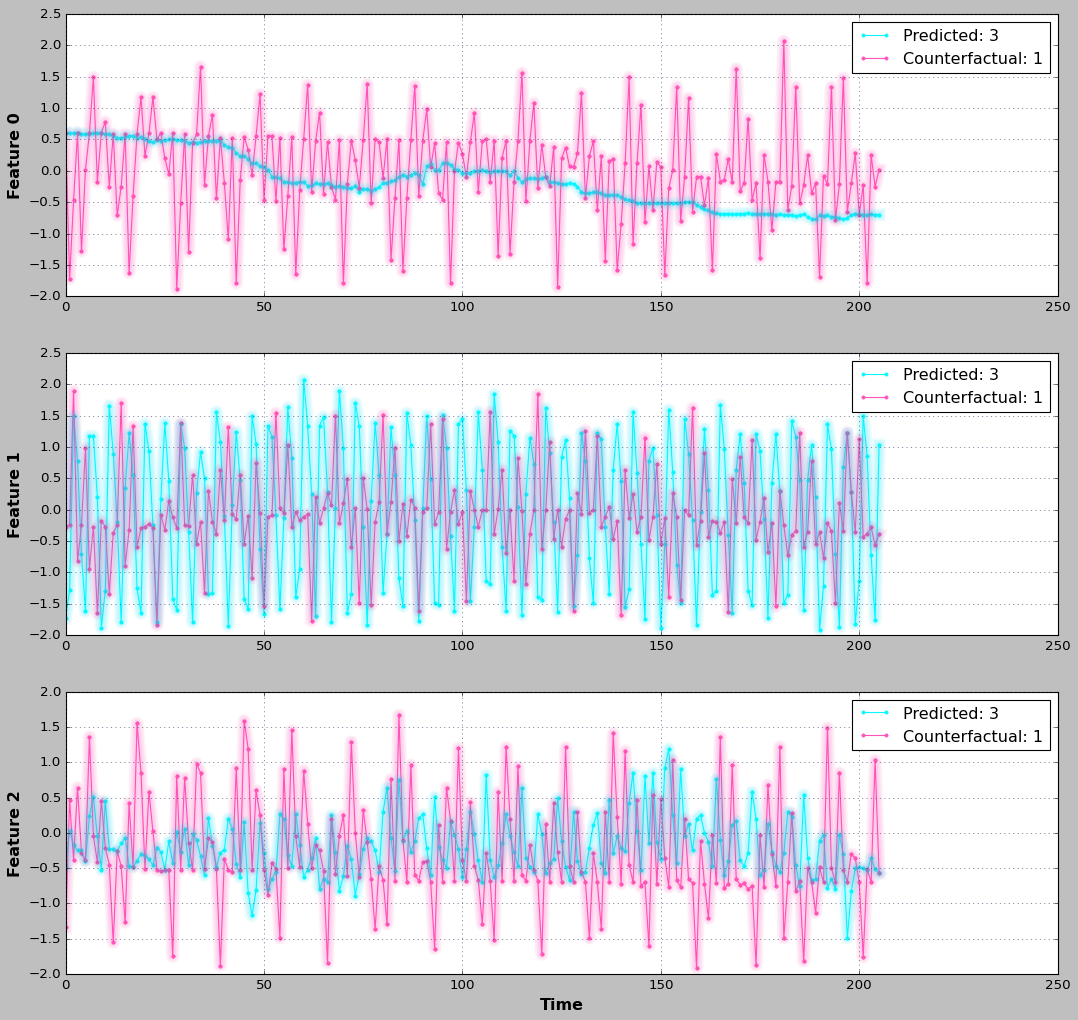

In [66]:
# Visualization of counterfactual

tsevo_exp.plot_in_one(observation_01,label_01[0],pop,np.argmax(label_cf),save_fig=f'./interp_figs/{model_name}_tsevo.png', figsize=(8*2,5*NumFeatures))

## 2. TSR_FA

In [67]:
from TSInterpret.InterpretabilityModels.Saliency.TSR import TSR, Saliency_PTY
tsr_FA_exp = Saliency_PTY(model, NumTimeSteps=NumTimesteps, NumFeatures=NumFeatures, method='FA', mode='time', tsr=True)

In [68]:
observation_01.shape

(206, 3)

In [69]:
exp_fa = tsr_FA_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

In [70]:
exp_fa.shape

(206, 3)

True
time mode


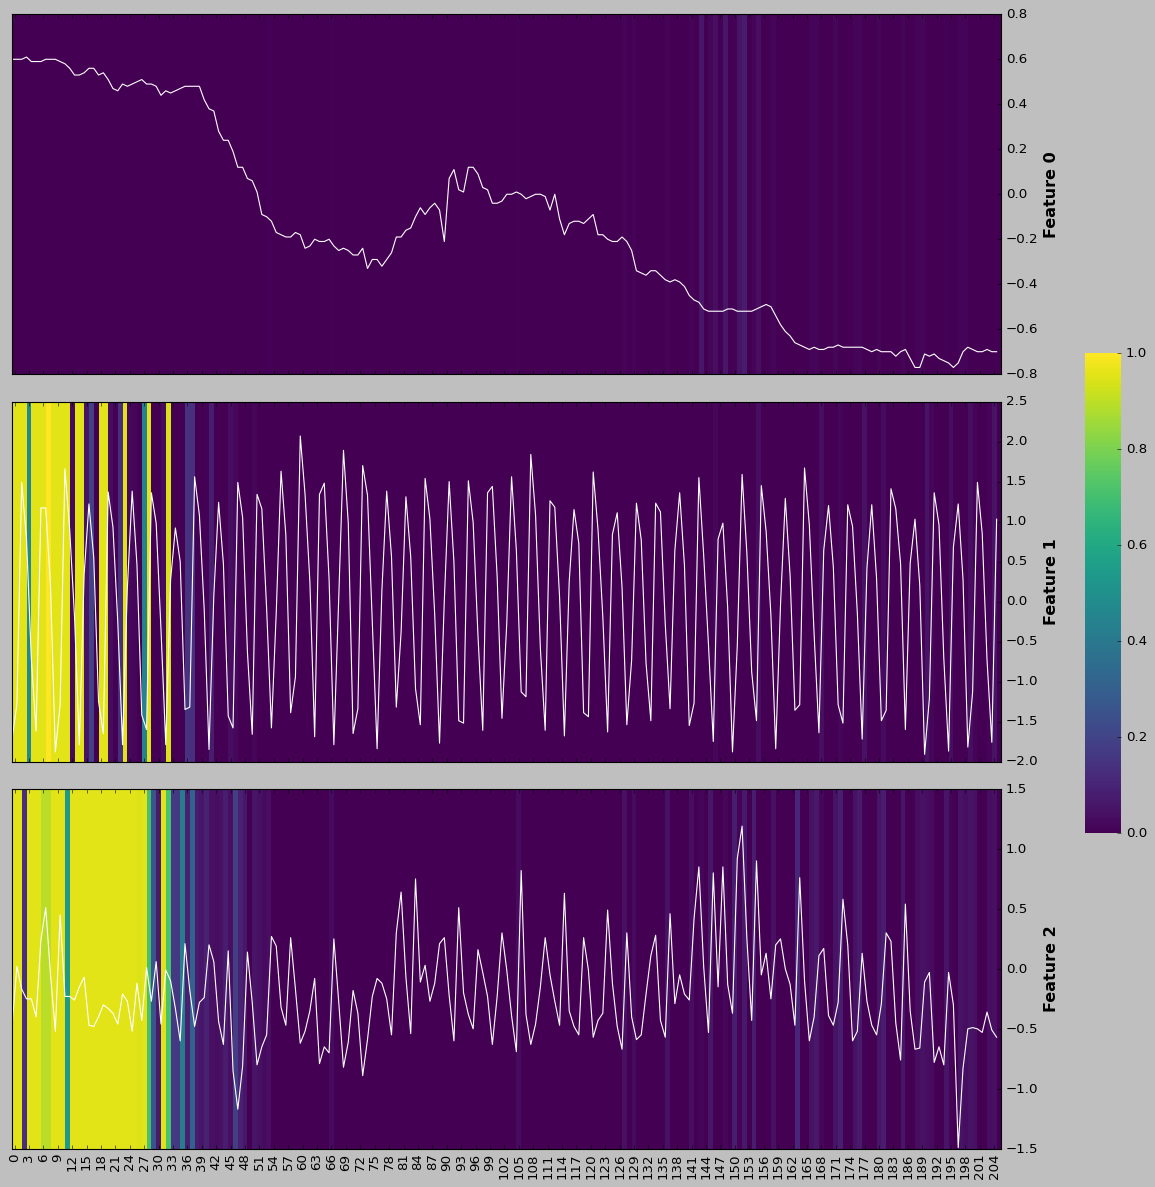

In [71]:
# Saliency heatmap

tsr_FA_exp.plot(observation_01[np.newaxis],exp_fa,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_FA.png')


## 3. TSR_Grad

In [72]:
tsr_GRAD_exp = Saliency_PTY(model, NumTimeSteps=NumTimesteps, NumFeatures=NumFeatures, method='GRAD', mode='time', tsr=True)

In [73]:
exp_grad = tsr_GRAD_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

True
time mode


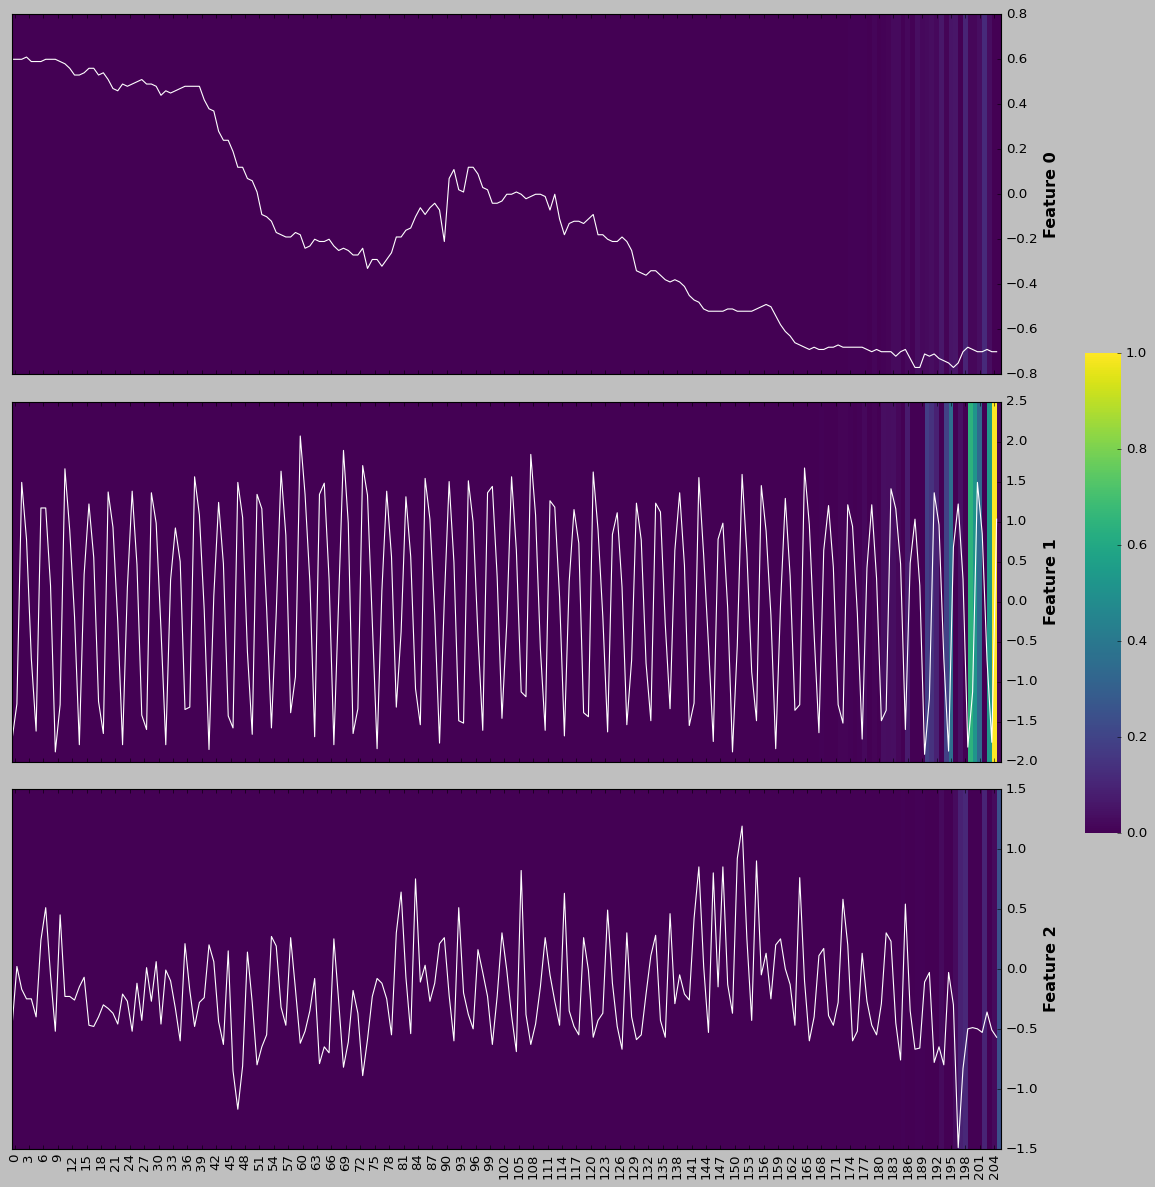

In [74]:

tsr_GRAD_exp.plot(observation_01[np.newaxis],exp_grad,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_Grad.png')


## 4. TSR_FO

In [75]:
tsr_FO_exp =  Saliency_PTY(model, NumTimeSteps=NumTimesteps, NumFeatures=NumFeatures, method='FO', mode='time', tsr=True)

In [76]:
exp_fo = tsr_FO_exp.explain(observation_01[np.newaxis], labels=label_01,TSR = True, attribution=0.0)

True
time mode


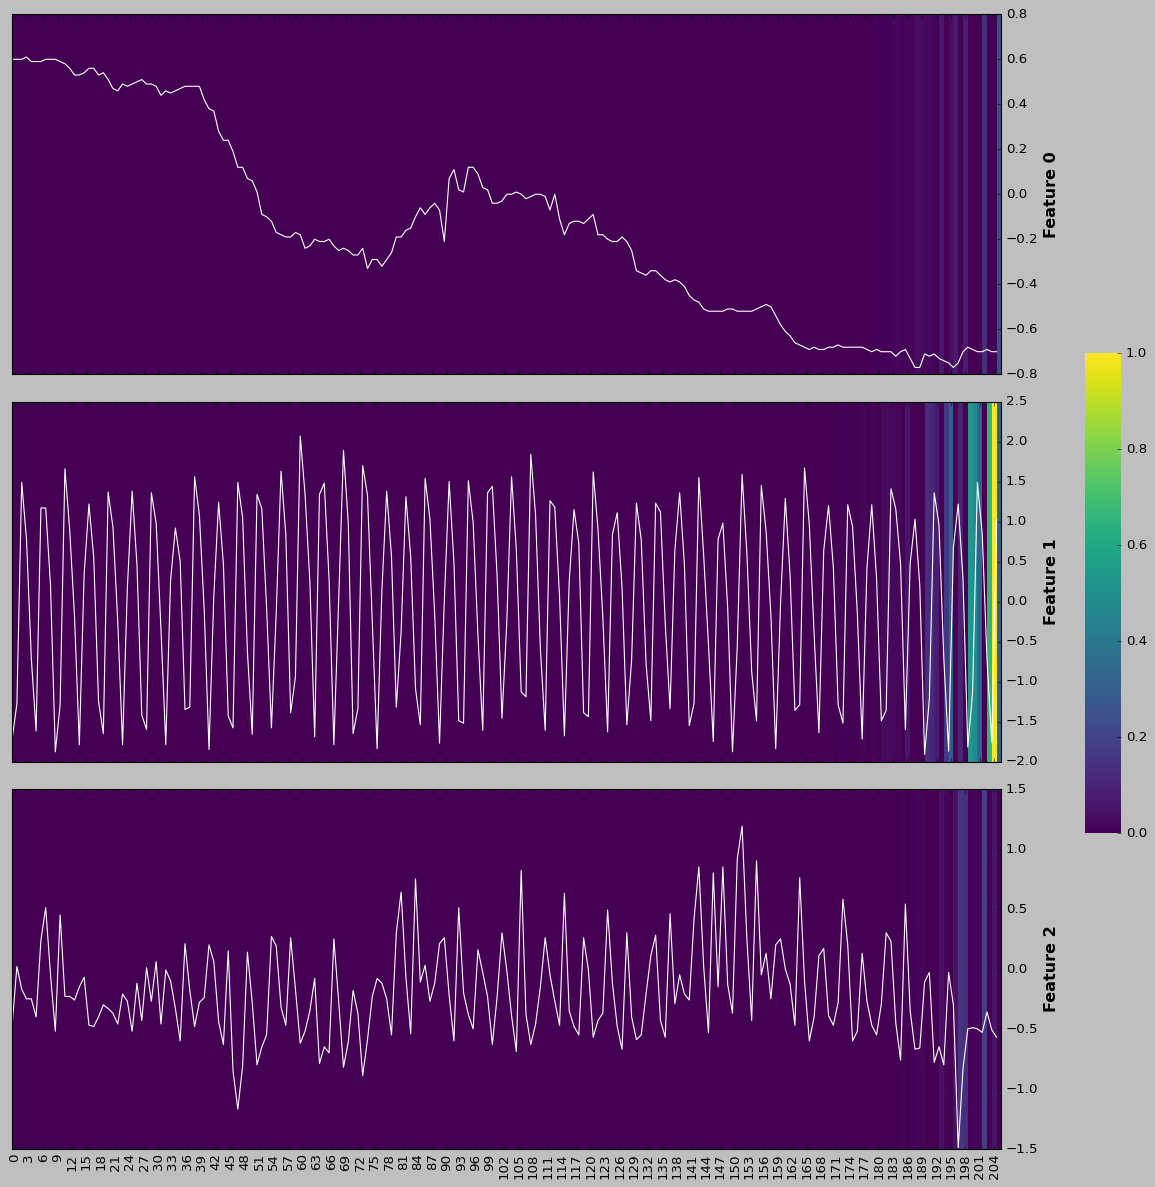

In [77]:
tsr_FO_exp.plot(observation_01[np.newaxis], exp_fo,figsize=(15,5*NumFeatures), save=f'./interp_figs/{model_name}_tsr_FO.png')